# Name: Srinibas Masanta
# Roll Number: 202318054

In [7]:
pip install pyspark

#### • Perform K-means clustering and Hierarchical clustering upon the dataset fetch 20 newsgroups link using PySpark.

In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml import Pipeline
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Clustering") \
    .getOrCreate()

# Fetch the 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Extract text data
documents = newsgroups_data.data

# Tokenization, stopword removal, and stemming
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

import nltk
nltk.download('punkt')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed_tokens)

preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Create a DataFrame from the preprocessed documents
documents_df = spark.createDataFrame(pd.DataFrame({'text': preprocessed_documents}))

# Apply TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=200)
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
pipeline_model = pipeline.fit(documents_df)
tfidf_data = pipeline_model.transform(documents_df)

# Perform K-means clustering
kmeans = KMeans(k=10, seed=1)
model_kmeans = kmeans.fit(tfidf_data)
predictions_kmeans = model_kmeans.transform(tfidf_data)

# Perform Hierarchical clustering (Bisecting K-means)
bkm = BisectingKMeans(k=10, seed=1)
model_bkm = bkm.fit(tfidf_data)
predictions_bkm = model_bkm.transform(tfidf_data)

# Show the clustering results
print("K-means clustering results:")
predictions_kmeans.select("text", "prediction").show()

print("Hierarchical clustering results:")
predictions_bkm.select("text", "prediction").show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


K-means clustering results:
+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|sure basher pen f...|         0|
|brother market vi...|         0|
|final said dream ...|         0|
|think scsi card d...|         0|
|old jasmin drive ...|         0|
|back high school ...|         0|
|ae dalla tri tech...|         0|
|stuff delet ok so...|         0|
|yeah second one b...|         0|
|christian mean so...|         0|
|blood lamb hard t...|         0|
|say histori untru...|         0|
|thou wilt shall w...|         8|
|kirlian imag beli...|         0|
|notion heliocentr...|         0|
|follow report eye...|         0|
|mani thank repli ...|         0|
|year ago almost b...|         0|
|suprem court seem...|         0|
|ed us argu gyrosc...|         0|
+--------------------+----------+
only showing top 20 rows

Hierarchical clustering results:
+--------------------+----------+
|                text|prediction|
+--------------------+-------

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# K-means silhouette score
silhouette_kmeans = evaluator.evaluate(predictions_kmeans)
print(f"Silhouette Score for K-means: {silhouette_kmeans}")

# Hierarchical clustering silhouette score
silhouette_bkm = evaluator.evaluate(predictions_bkm)
print(f"Silhouette Score for Hierarchical clustering: {silhouette_bkm}")

Silhouette Score for K-means: 0.9503406892025303
Silhouette Score for Hierarchical clustering: 0.2709970734973112


The silhouette score is a metric used to evaluate the quality of clusters in unsupervised learning. It provides measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where:

- A score close to +1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This suggests that the object is distinctly clustered.
- A score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.
- A score close to -1 indicates that the object is likely placed in the wrong cluster.

#### • Represent each document using TfIdf matrix.

In [20]:
# Access the TF-IDF matrix
tfidf_matrix = tfidf_data.select("features").collect()

# Show TF-IDF matrix for the first document
print(tfidf_matrix[0])

Row(features=SparseVector(200, {1: 1.9146, 7: 1.593, 9: 1.7424, 10: 1.4611, 19: 1.3856, 21: 1.4595, 22: 1.5322, 41: 1.9089, 44: 1.9007, 46: 2.0113, 51: 2.728, 53: 2.8517, 55: 1.1685, 56: 1.5205, 67: 1.643, 71: 1.5715, 73: 1.594, 75: 3.8678, 77: 1.4247, 82: 4.9621, 96: 1.5718, 106: 1.9222, 108: 1.481, 114: 8.8116, 117: 1.9558, 118: 1.6029, 119: 4.3786, 120: 1.37, 124: 1.115, 134: 1.945, 143: 4.5544, 144: 2.764, 147: 1.2862, 149: 1.5744, 154: 1.4989, 157: 1.0564, 158: 2.2476, 169: 3.3281, 173: 1.1538, 175: 3.3053, 180: 3.7872, 186: 1.5531, 187: 1.5159, 189: 3.7371, 191: 1.4752, 192: 1.3663, 194: 1.6234, 195: 1.6348}))


#### • For each of the K-means clustering techniques use K(number of clusters) as a hyperparameter and find the WCSS for each k-value. Find the optimal number of clusters using the elbow method.

In [31]:
# List to store K values and their corresponding WCSS
k_values = []
wcss_values = []

# Try different values of k
for k in range(2, 11):  # Adjusted range to start from 2
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(tfidf_data)
    wcss = model.summary.trainingCost
    k_values.append(k)
    wcss_values.append(wcss)

# Print K values and their corresponding WCSS
print("K Values\tWCSS")
for k, wcss in zip(k_values, wcss_values):
    print(f"{k}\t\t{wcss}")

K Values	WCSS
2		50762697.25851829
3		38462740.23751265
4		37056763.419929296
5		36818691.4474009
6		26813025.38962821
7		25023439.605241165
8		24288481.350303248
9		22869368.931771483
10		21325140.33235629


As the number of clusters (K) increases, the WCSS tends to decrease. This is expected because with more clusters, the data points can be grouped more closely together, leading to smaller within-cluster distances.

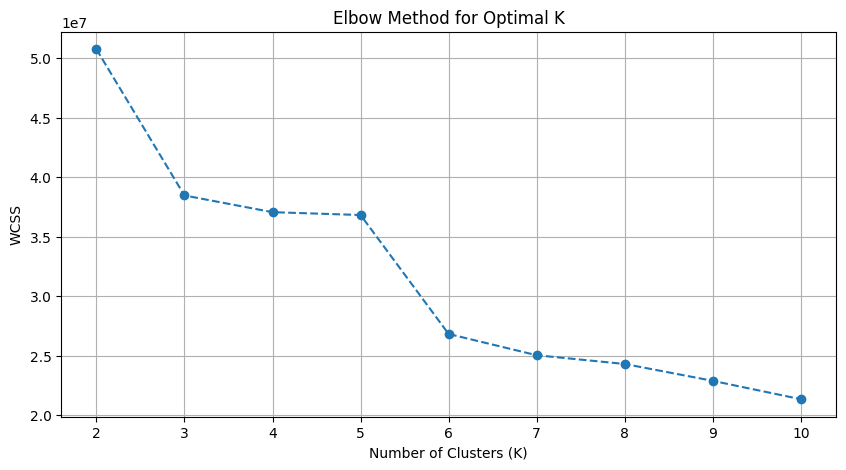

In [29]:
import matplotlib.pyplot as plt

# List to store WCSS values for different k-values
wcss_values = []

# Try different values of k
for k in range(2, 11):  # Adjusted range to start from 2
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(tfidf_data)
    wcss = model.summary.trainingCost
    wcss_values.append(wcss)

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss_values, marker='o', linestyle='--')  # Adjusted range
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(2, 11))  # Adjusted range
plt.grid(True)
plt.show()

In [32]:
# Find the optimal K value
optimal_k = wcss_values.index(min(wcss_values)) + 2  # Add 2 to index to get the actual value of K
print("Optimal K value:", optimal_k)

Optimal K value: 10


#### • Apply Agglomerative clustering for clustering the documents and find the optimal number of clusters using dendrogram diagrams.

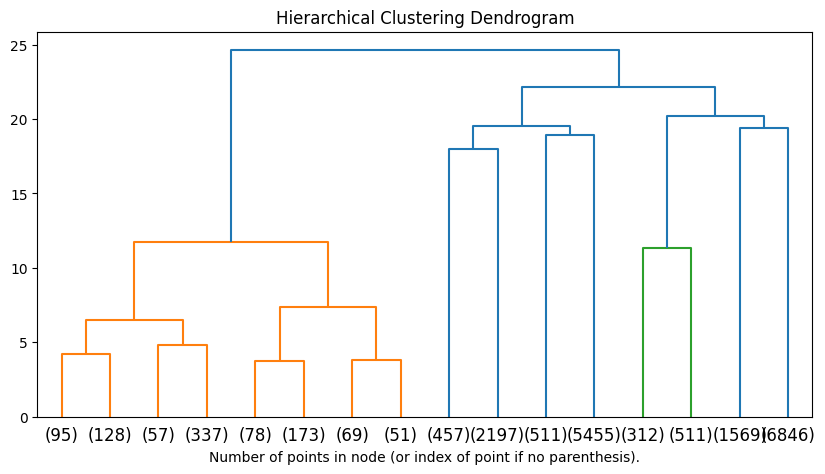

In [42]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

vectorizer = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7, stop_words='english')
X = vectorizer.fit_transform(newsgroups.data)
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_reduced = lsa.fit_transform(X)

# Apply Agglomerative clustering
agglomerative_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = agglomerative_clustering.fit(X_reduced)

# Function to plot the dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [48]:
# Terminate Spark Session
spark.stop()